# Визуализация работы сверточных сетей

Мы обучим сверточную нейронную сеть на TensorFlow для распознавания всем известных рукописных цифр из набора данных MNIST. Потом попытаемся визуализировать активацию нейронов на разных слоях сети. 

Сначала обычные **импорты**:

In [25]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import math

Библиотека [`slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) из `tf.contrib` позволяет упростить написание моделей, например, для создания сверточного слоя писать
```py
    net = slim.conv2d(input, 128, [3, 3], scope='conv1_1')
```    
вместо 
```py
    with tf.name_scope('conv1_1') as scope:
        kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                             stddev=1e-1), name='weights')
        conv = tf.nn.conv2d(input, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                             trainable=True, name='biases')
        bias = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(bias, name=scope)
```
Для загрузки данных MNIST пользуемся объектом `mnist` из `tf.examples.tutorials`.

In [26]:
# Подавить предупреждения об устаревших функциях из input_data
# original_warnlevel = tf.logging.get_verbosity()
#tf.logging.set_verbosity(tf.logging.ERROR)

# получить данные
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# восстановить настройки ведения логов
#tf.logging.set_verbosity(original_warnlevel)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Поглядим на **изображения**:

In [21]:
(mnist.train.images.shape, mnist.test.images.shape)

((55000, 784), (10000, 784))

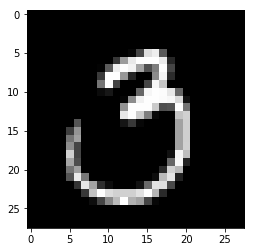

In [22]:
plt.imshow(mnist.train.images[0].reshape(28,28), cmap='gray')

Поглядим на **ответы**:

In [23]:
mnist.train.labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

Как видим, это one-hot векторы.

Теперь **определяем сверточную сеть**. Три набора convolution -> pooling слоев, за которыми следует полносвязный softmax-слой. Для начала выбран настройки 5, 5, 20 to begin with. Можно понастраивать число сверточных фильтров в каждом слое. Вывод этих фильтров мы и хотим посмотреть.

In [17]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784], name="x-in")
true_y = tf.placeholder(tf.float32, [None, 10], name="y-in")
keep_prob = tf.placeholder("float")

x_image  = tf.reshape(x,[-1, 28, 28, 1])
hidden_1 = slim.conv2d(x_image, 5, [5, 5])
pool_1   = slim.max_pool2d(hidden_1, [2, 2])
hidden_2 = slim.conv2d(pool_1, 5, [5, 5])
pool_2   = slim.max_pool2d(hidden_2, [2, 2])
hidden_3 = slim.conv2d(pool_2, 20, [5, 5])
hidden_4 = slim.dropout(hidden_3, keep_prob)
out_y    = slim.fully_connected(slim.flatten(hidden_4), 10, activation_fn=tf.nn.softmax)

cross_entropy =     -tf.reduce_sum(true_y * tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy =           tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step =         tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Нашел код, который использует TensorBoard внутри Jupyter-тетрадки. Не полностью работает вся интерактивность, и загружается очень долго. Но все равно прикольно:

In [13]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

    
show_graph(tf.get_default_graph().as_graph_def())

Градиентный спуск с батчами с Adam optimization.

In [19]:
batchSize = 50
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(1001):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x:batch[0],true_y:batch[1], keep_prob:0.5})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch[0],true_y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.28
step 200, training accuracy 0.78
step 300, training accuracy 0.7
step 400, training accuracy 0.82
step 500, training accuracy 0.94
step 600, training accuracy 0.84
step 700, training accuracy 0.88
step 800, training accuracy 0.88
step 900, training accuracy 0.84
step 1000, training accuracy 0.86


In [20]:
testAccuracy = sess.run(accuracy, feed_dict={x:mnist.test.images,true_y:mnist.test.labels, keep_prob:1.0})
print("test accuracy %g"%(testAccuracy))

test accuracy 0.8984


Две функции для визуализации сети. Первая получает активации в заданном слое для данного изображения, вторая рисует их на сетке.

In [ ]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

Теперь прогоняем изображение.

In [ ]:
imageToUse = mnist.test.images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")

Активация нейронов первого слоя:

In [ ]:
getActivations(hidden_1,imageToUse)

Активация нейронов второго слоя

In [ ]:
getActivations(hidden_2,imageToUse)

и третьего

In [ ]:
getActivations(hidden_3,imageToUse)

## Задание 
Проиллюстрируйте работы сети на четырех изображениях, отличающихся друг от друга лишь сдвигами (1 по x), 1 по y и (1,1).